# Semi Regular Polygon (3.3.4.3.4)

<img src="./img/semi_regular_polygon_33434.png" width="200" >

We define some scripts to create the cutting patterns for one of the 8 semi-regular tesselations.<br>
In particular for the  `triangle` + `square` tesselation defined by vertex `(3.3.4.3.4)`.

### Strategy

- We define a basic shape made of 2 squares and 4 triangles using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="600">

In [75]:
# Imports
import math
from math import sin, cos, pi

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

In [76]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg
)

### Canvas and Polygon sizes

In [77]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 170
tabica_width = 905

square_radius = 18 # (21,-4)
triangle_radius = square_radius * math.sin(math.pi/4)/math.sin(math.pi/3)

frame_shift = 0  # move box that selects region of interest down by Xmm
INSET_DISTANCE = 3.2   # X ratio gives gaps of about 2Xmm solid channels

bottom_margin = 26 # solid margin, at bottom of step
top_margin = tabica_height - 120 - bottom_margin # solid margin, at bottom of step

side_margin = 26 # solid margin left and right

### Polygon creation

In [78]:
def create_regular_polygon(center_x, center_y, radius, nr_points):
    angle = 2 * pi / nr_points
    polygon_points = []

    for i in range(nr_points):
        x = center_x + radius * cos(i * angle)
        y = center_y + radius * sin(i * angle)
        polygon_points.append((x, y))

    return Polygon(polygon_points)

# Create a triangle (3 sides)
triangle = create_regular_polygon(0,0,triangle_radius, 3)

# Create a square (4 sides)
square = create_regular_polygon(0,0,square_radius, 4)


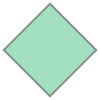

In [79]:
square

In [80]:
def create_regular_polygon(center_x, center_y, radius, nr_points):
    angle = 2 * math.pi / nr_points
    polygon_points = []

    for i in range(nr_points):
        x = center_x + radius * math.cos(i * angle)
        y = center_y + radius * math.sin(i * angle)
        polygon_points.append((x, y))

    return Polygon(polygon_points)

# Create a triangle (3 sides)
triangle = create_regular_polygon(0,0,triangle_radius, 3)

# Create a square (4 sides)
square = create_regular_polygon(0,0,square_radius, 4)
square2 = create_regular_polygon(0,0,square_radius, 4)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [81]:
square = create_regular_polygon(0,0,square_radius, 4)
triangle = create_regular_polygon(0,0,triangle_radius, 3)

triangle_up = affinity.rotate(triangle, 90, origin="centroid")
triangle_down = affinity.rotate(triangle, -90, origin="centroid")
triangle_right = affinity.rotate(triangle, 0, origin="centroid")

square = affinity.rotate(square, -45, origin="centroid")
top_right_square = affinity.translate(square, 2*square_radius*math.sin(math.pi/4), 
                                        2*square_radius*math.cos(math.pi/4))

s2_vertices = list(top_right_square.exterior.coords)[:-1]
bottom_left_vertex = s2_vertices[3]
square_rotated = affinity.rotate(top_right_square, 180/6, origin=bottom_left_vertex)



polygon_dict = {}
polygon_dict['S0'] = square
polygon_dict['S1'] = square_rotated

polygon_dict['T1'] = affinity.translate(triangle_up, 
                                        0, 
                                        triangle_radius*(cos(math.pi/3)) +
                                        square_radius*sin(math.pi/4)
                                        )
polygon_dict['T2'] = affinity.translate(triangle_right, triangle_radius*(cos(math.pi/3)) +
                                        square_radius*sin(math.pi/4), 0)

triangle_left = affinity.rotate(triangle, 180, origin="centroid")

t2 = affinity.translate(triangle_right, triangle_radius*(cos(math.pi/3)) +
                                        square_radius*sin(math.pi/4), 0)
                                
polygon_dict['T3'] = affinity.rotate(t2, 180/3, origin=bottom_left_vertex)

t3 = affinity.rotate(t2, 180/3, origin=bottom_left_vertex)
t3_vertices = list(t3.exterior.coords)[:-1]
t3_vertex = t3_vertices[0]                                                                         

polygon_dict['T4'] = affinity.rotate(t3, 180 + 180/6, origin=t3_vertex)



### Plotting Dictionaries of Shapes

<img src="./img/semi_regular_polygon_33434.png" width="200" >

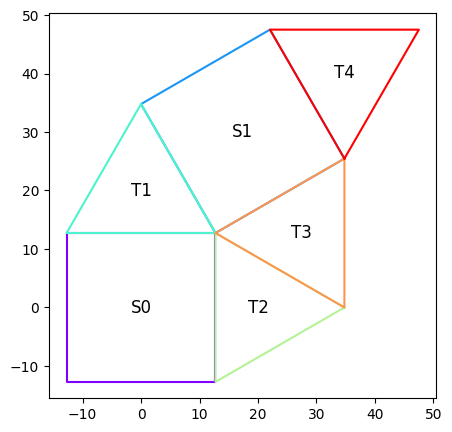

In [82]:
plot_polygon_dict(polygon_dict)

### Translations
The collection of polygons above can be translated to fill the plane as shown below:

In [83]:
# Define the translation
x_offset = square_radius*sin(pi/4)
y_offset = -square_radius*sin(pi/4)*(2 + 1/math.tan(pi/6))

# Translate all polygons
translated_polygons_1 = {
    f"{key}-t": affinity.translate(poly, x_offset, y_offset) for key, poly in polygon_dict.items()
}

x_offset = square_radius*sin(pi/4)*(2 + 1/math.tan(pi/6))
y_offset = square_radius*math.sin(math.pi/4)  

translated_polygons_2 = {
    f"{key}-tt": affinity.translate(poly, x_offset, y_offset) for key, poly in polygon_dict.items()
}

print(translated_polygons_1)
print(translated_polygons_2)

{'S0-t': <POLYGON ((25.456 -60.229, 25.456 -34.773, 0 -34.773, -1.776e-15 -60.229, 25...>, 'S1-t': <POLYGON ((47.501 -22.045, 34.773 0, 12.728 -12.728, 25.456 -34.773, 47.501 ...>, 'T1-t': <POLYGON ((12.728 -12.728, 0 -34.773, 25.456 -34.773, 12.728 -12.728))>, 'T2-t': <POLYGON ((47.501 -47.501, 25.456 -34.773, 25.456 -60.229, 47.501 -47.501))>, 'T3-t': <POLYGON ((47.501 -22.045, 25.456 -34.773, 47.501 -47.501, 47.501 -22.045))>, 'T4-t': <POLYGON ((47.501 -22.045, 60.229 -7.105e-15, 34.773 0, 47.501 -22.045))>}
{'S0-tt': <POLYGON ((60.229 0, 60.229 25.456, 34.773 25.456, 34.773 0, 60.229 0))>, 'S1-tt': <POLYGON ((82.275 38.184, 69.547 60.229, 47.501 47.501, 60.229 25.456, 82.27...>, 'T1-tt': <POLYGON ((47.501 47.501, 34.773 25.456, 60.229 25.456, 47.501 47.501))>, 'T2-tt': <POLYGON ((82.275 12.728, 60.229 25.456, 60.229 3.553e-15, 82.275 12.728))>, 'T3-tt': <POLYGON ((82.275 38.184, 60.229 25.456, 82.275 12.728, 82.275 38.184))>, 'T4-tt': <POLYGON ((82.275 38.184, 95.003 60.229, 69.547

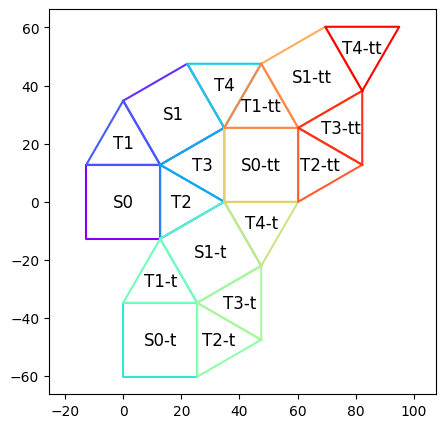

In [84]:
super_polys = { **polygon_dict, **translated_polygons_1, **translated_polygons_2}
plot_polygon_dict(super_polys)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [85]:
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define two translations
- Up and to the right (as shown in plot above)
- Down and to the right 

In [86]:
# Translate all polygons
def translate_polygon_down(polygon_list, nr_translations): 
    """
    takes a list of polygons and applies the "to-the-right"
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    # Define the basic RIGHT-DOWN translation
    x_right = square_radius*sin(pi/4)
    y_down = -square_radius*sin(pi/4)*(2 + 1/math.tan(pi/6))
    
    right_polygons = [
    affinity.translate(poly, x_right*nr_translations, y_down*nr_translations) for poly in polygon_list
    ]
    return right_polygons

def translate_polygon_up(polygon_list, nr_translations):
    """
    takes a list of polygons and applies the up and to the right
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    # Define the basic DOWN + RIGHT translation
    x_right = square_radius*sin(pi/4)*(2 + 1/math.tan(pi/6))
    y_up = square_radius*math.sin(math.pi/4) 

    up_polygons = [
    affinity.translate(poly, x_right*nr_translations, y_up*nr_translations) for poly in polygon_list
    ]
    return up_polygons


### Plotting Lists of Polygons

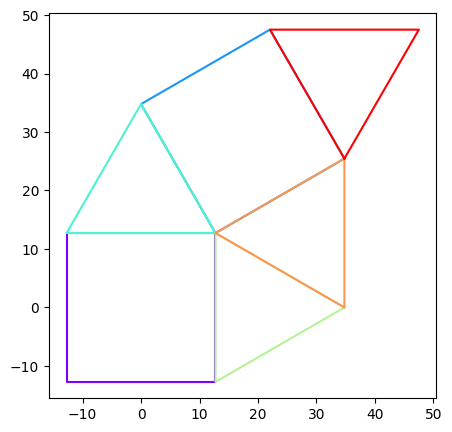

In [87]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

1. We create a horizontal row made of copies of the "basic polygon group"
   * This row is created by translating the last copied group to the right 
   * We repeat this process until we have a big enough column (about 40 copies)

2. We then select the whole row created and make two copies translated up and right.


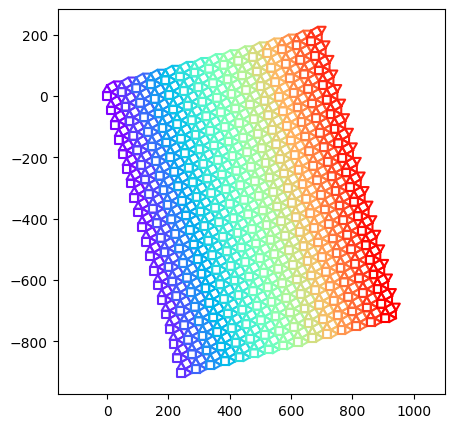

In [88]:
first_row = []
for nr_copies in range(20):
    n_copy = translate_polygon_down(initial_polygon_list, nr_copies)
    first_row += n_copy

full_polygon_list = []
for nr_copies in range(15):
    copy_row = translate_polygon_up(first_row, nr_copies)
    full_polygon_list += copy_row

# Rotate the whole pattern


plot_polygon_list(full_polygon_list)
# save_polygons_to_svg(full_poly, filename='tramo_2.1.svg')

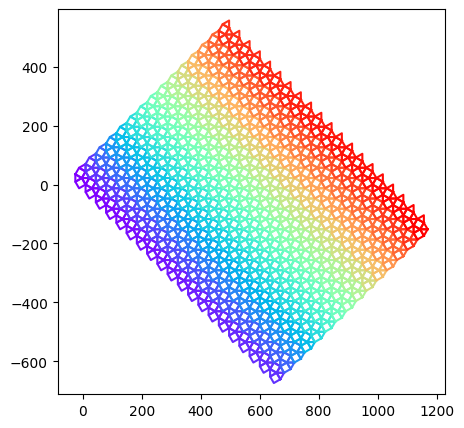

In [89]:
square_vertices = list(square.exterior.coords)[:-1]
bottom_left_vertex = square_vertices[3]

# polygon_dict = {key: affinity.rotate(poly, pi/6, origin=bottom_left_vertex) for key, poly in polygon_dict.items()}
rotated_polygons = [affinity.rotate(poly, 180/6, origin=bottom_left_vertex) for poly in full_polygon_list]
plot_polygon_list(rotated_polygons)

full_polygon_list = rotated_polygons

# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [90]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [91]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

In [92]:
centered_frame = affinity.translate(centered_frame, 0, frame_shift)

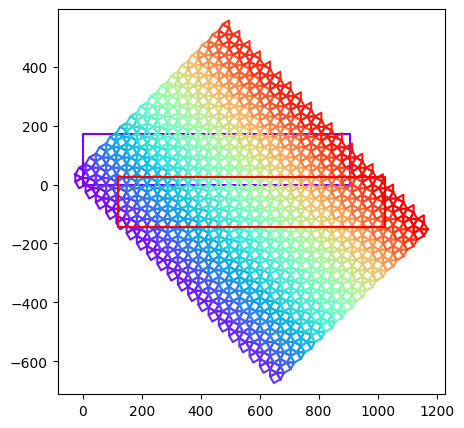

In [93]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

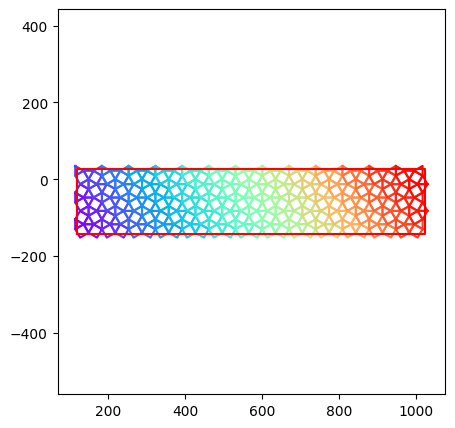

In [94]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [95]:
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))    

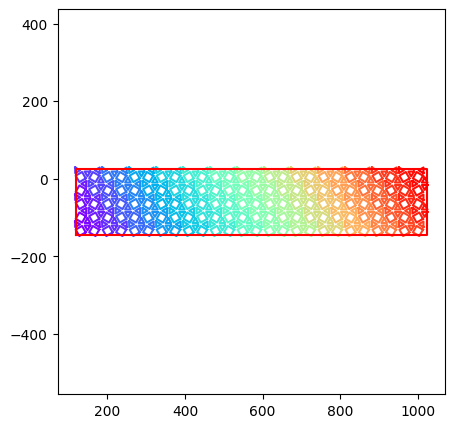

In [96]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Creating a border with margin  

1. We define some bands around the frame

In [97]:
side_inset = 22 # solid margin for sides of step

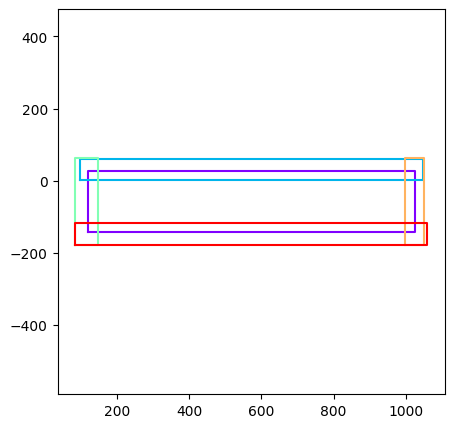

In [98]:
top_band = polygons([[centered_frame.bounds[0] - top_margin, centered_frame.bounds[3] - top_margin],
                    [centered_frame.bounds[0] - top_margin, centered_frame.bounds[3] + top_margin + 10],
                    [centered_frame.bounds[2] + top_margin, centered_frame.bounds[3] + top_margin + 10],
                    [centered_frame.bounds[2] + top_margin, centered_frame.bounds[3] - top_margin]])

left_band = polygons([[centered_frame.bounds[0] - side_margin - 10, centered_frame.bounds[1] - side_margin - 10], # 
                      [centered_frame.bounds[0] - side_margin - 10, centered_frame.bounds[3] + side_margin + 10],
                      [centered_frame.bounds[0] + side_margin, centered_frame.bounds[3] + side_margin + 10],
                      [centered_frame.bounds[0] + side_margin, centered_frame.bounds[1] - side_margin - 10]])

right_band = polygons([[centered_frame.bounds[2] - side_margin, centered_frame.bounds[1] - side_margin - 10],
                      [centered_frame.bounds[2] - side_margin, centered_frame.bounds[3] + side_margin + 10],
                      [centered_frame.bounds[2] + side_margin, centered_frame.bounds[3] + side_margin + 10],
                      [centered_frame.bounds[2] + side_margin, centered_frame.bounds[1] - side_margin - 10]])

bottom_band = polygons([[centered_frame.bounds[0] - bottom_margin - 10, centered_frame.bounds[1] - bottom_margin - 10],
                        [centered_frame.bounds[0] - bottom_margin - 10, centered_frame.bounds[1] + bottom_margin],
                        [centered_frame.bounds[2] + bottom_margin + 10, centered_frame.bounds[1] + bottom_margin],
                        [centered_frame.bounds[2] + bottom_margin + 10, centered_frame.bounds[1] - bottom_margin - 10]])

plot_polygon_list([centered_frame, top_band, left_band, right_band, bottom_band])

In [99]:
def is_point_inside_rectangle(point, rect):
    """Check if a point is inside a rectangle."""
    x, y = point
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_polygon_inside_rectangle(polygon, rect):
    """Check if any vertices of a polygon are inside a rectangle."""
    return any(is_point_inside_rectangle(vertex, rect) for vertex in polygon.exterior.coords)

In [100]:
top_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, top_band)]
left_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, left_band)]
right_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, right_band)]
bottom_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, bottom_band)]

# deduplicate the list of polygons overlapped by each band:
band_polygons = list(set(top_band_polygons + left_band_polygons + right_band_polygons + bottom_band_polygons))
# keep the polygons outside of bands for later:
all_other_polygons = [polygon for polygon in inset_polygon_list if polygon not in band_polygons]

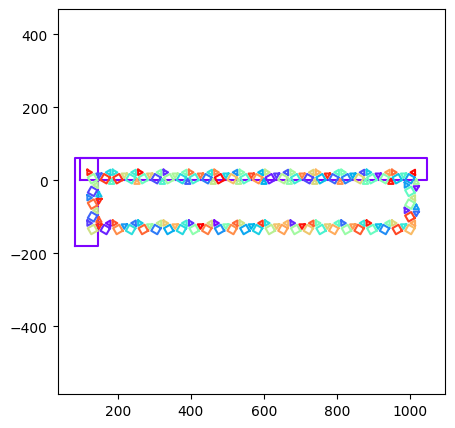

In [101]:
plot_polygon_list([top_band] + [left_band] + band_polygons)

In [102]:
cropped_polygons = []
for poly in band_polygons:
    bit_to_keep_t = poly.difference(top_band)
    bit_to_keep_b = bit_to_keep_t.difference(bottom_band)
    bit_to_keep_l = bit_to_keep_b.difference(left_band)
    bit_to_keep = bit_to_keep_l.difference(right_band)
    cropped_polygons.append(bit_to_keep)


# some polygons are cropped down to nothing (no coordinates), so we need to remove them
cropped_polygons = [poly for poly in cropped_polygons if poly.exterior] 

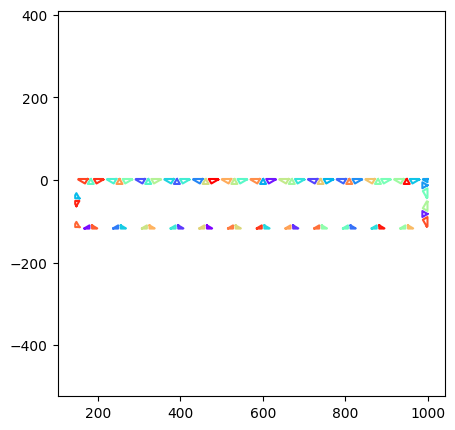

In [103]:
plot_polygon_list(cropped_polygons)

In [104]:
final_polygons =  all_other_polygons + cropped_polygons + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [105]:
len(final_polygons)

286

In [106]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 9:
        final_polygons.remove(poly)
    

In [107]:
len(final_polygons)

286

### Save POLYGONS to SVG

### SAVE POLYGONS to SVG with **RESCALING**

# SAVE


In [108]:
save_polygon_list_to_svg(final_polygons, filename='tabica_2.2.svg')


In [109]:
# coords = [(coord[0], max_y - coord[1]) for coord in polygon.exterior.coords]
for x in range(5):
    print(final_polygons[1].exterior.coords[x])


(178.81285306361283, -61.400455161232415)
(169.28493100225498, -77.90330026206064)
(152.78208590142683, -68.37537820070276)
(162.31000796278468, -51.87253309987456)
(178.81285306361283, -61.400455161232415)


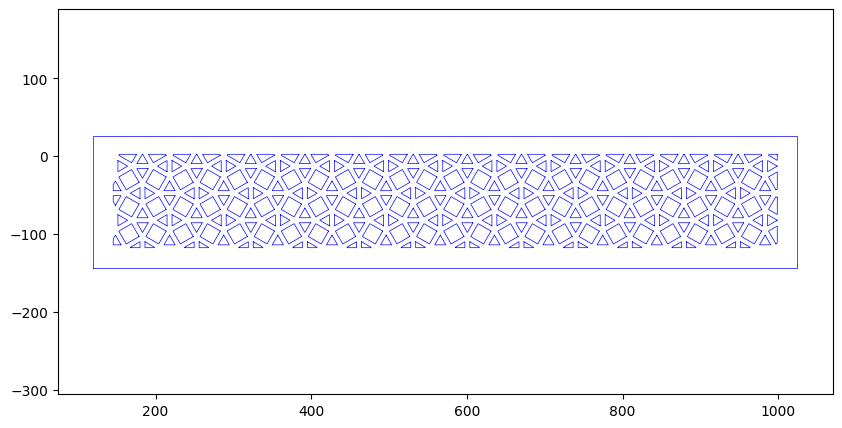

In [110]:
blue_plot(final_polygons)

In [111]:
# Save as PNG
plt.figure(figsize=(12, 8))
for polygon in (final_polygons):
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='blue', linewidth=0.5)
plt.axis('equal')
plt.savefig('tabica_2.1.png', dpi=300, bbox_inches='tight')
plt.close()